In [32]:
# !pip install imblearn

In [33]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import randint
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


In [34]:
# data paths
transaction = 'dataset/optical_care_transaction_opticiens.csv'
historical = 'dataset/historical_data.csv'
target = 'dataset/almerys_fraudulent_optician_id.csv'

norm_selected = 'dataset/normalized_selected.csv'

In [35]:
# feature selection
def select_features(csv_path, out_path):
    df = pd.read_csv(csv_path, sep=';')
    # drop features as based on the feature analysis
    df_dropped = df.drop(['PEC_REF', 'PEC_CRE', 'cor_cylindre_VG', 'cor_cylindre_VD', 'age_moyen', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)
    df_dropped.to_csv(out_path, index = False)
    return df_dropped


def scale_features(df):
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
    df_ = df.drop(['ref_PS'], axis=1)
    
    cols = df_.columns.tolist()
    df_ = qt.fit_transform(df_)

    df_ = pd.DataFrame(df_)
    df_.columns = cols
    
    # centering data
    df_ = df_ - df_.mean()

    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    df_[:] = scaler.fit_transform(df_[:])
    
    df_['ref_PS'] = df['ref_PS']
    
    return df_


In [36]:
select_features(transaction, 'results/selected_features.csv')

target_df = pd.read_csv(target)
df = pd.read_csv(transaction, sep=';')
selected_df = pd.read_csv('results/selected_features.csv')
scaled_df = scale_features(df)
scaled_selected_df = scale_features(selected_df)
scaled_selected_df

,dep_identique,dep_limit,dep_non_limit,PEC_ANN,PEC_FAC,Prix_monture,Prix_verres,Prix_equipement,Pourcent_remise_monture,Pourcent_remise_total,cor_sphere_VD,cor_addition_VD,cor_sphere_VG,cor_addition_VG,facteur_correction,nb_prescripteurs,nb_PEC_par_prescripteurs,ref_PS
0,0.545160,0.479209,0.508214,0.445344,0.488025,0.316658,0.365870,0.321490,0.000000,0.000000,0.463206,0.462478,0.436189,0.462516,0.422236,0.576814,0.461864,8c47fdd7c69650b
1,1.000000,0.000000,0.000000,0.642591,0.434677,0.416078,0.402383,0.383819,0.635683,0.615910,0.573539,0.431220,0.521657,0.452401,0.388158,0.475362,0.505432,89bf4429f3ebda1
2,0.538266,0.500121,0.000000,0.563132,0.519189,0.654697,0.487765,0.568522,0.000000,0.000000,0.453760,0.448682,0.442451,0.448821,0.492149,0.475362,0.442451,5076215e2ee1797
3,0.556113,0.000000,0.516366,0.000000,0.596763,0.643054,0.481381,0.557177,0.000000,0.000000,0.504466,0.405017,0.521657,0.405017,0.375774,0.441147,0.604031,3a771e3f5cbc3b2
4,0.367472,0.000000,0.747674,0.658133,0.555257,0.629997,0.502931,0.561588,0.000000,0.000000,0.399146,0.000000,0.397670,0.000000,0.418098,0.358842,0.361276,ced6f62ac55fd34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,0.436719,0.587595,0.000000,0.572466,0.374531,0.519911,0.625964,0.608714,0.460310,0.458839,0.342792,0.618306,0.367247,0.618463,0.694316,0.536704,0.573216,c335633c0fbe713
12612,0.500965,0.532840,0.000000,0.461472,0.425487,0.443390,0.627585,0.592971,0.651442,0.664639,0.564334,0.544622,0.521657,0.544622,0.505915,0.453081,0.462516,72373e7fa1ab691
12613,0.492391,0.525511,0.522648,0.678748,0.344221,0.501244,0.385492,0.401966,0.000000,0.453559,0.460162,0.401192,0.452380,0.401105,0.534532,0.475362,0.526387,997171895d121ff
12614,0.522524,0.514777,0.000000,0.658133,0.388494,0.447224,0.572949,0.542267,0.535789,0.531824,0.323249,0.617894,0.319757,0.618242,0.660031,0.413495,0.695516,8759d1c2aa42bb8


In [37]:
# Create a new column 'class' in df1 and initialize it with 0
df['class'] = 0

# Check if the 'ref_PS' value from df1 exists in df2
df.loc[df['ref_PS'].isin(target_df['ref_PS']), 'class'] = 1
df

# Create a new column 'class' in df1 and initialize it with 0
scaled_df['class'] = 0

# Check if the 'ref_PS' value from df1 exists in df2
scaled_df.loc[scaled_df['ref_PS'].isin(target_df['ref_PS']), 'class'] = 1
scaled_df

,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,taux_non_ventes,...,cor_addition_VD,cor_sphere_VG,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,ref_PS,class
0,0.525511,0.545160,0.479209,0.508214,0.642520,0.445344,0.000000,0.488025,0.476234,0.536160,...,0.462478,0.436189,0.447985,0.462516,0.422236,0.498181,0.576814,0.461864,8c47fdd7c69650b,0
1,0.481303,1.000000,0.000000,0.000000,0.582250,0.642591,0.000000,0.434677,0.502534,0.588697,...,0.431220,0.521657,0.474364,0.452401,0.388158,0.541061,0.475362,0.505432,89bf4429f3ebda1,0
2,0.455109,0.538266,0.500121,0.000000,0.466392,0.563132,0.644802,0.519189,0.000000,0.429968,...,0.448682,0.442451,0.549932,0.448821,0.492149,0.366282,0.475362,0.442451,5076215e2ee1797,0
3,0.503741,0.556113,0.000000,0.516366,0.533865,0.000000,0.559582,0.596763,0.000000,0.396368,...,0.405017,0.521657,0.000000,0.405017,0.375774,0.334403,0.441147,0.604031,3a771e3f5cbc3b2,1
4,0.347639,0.367472,0.000000,0.747674,0.000000,0.658133,0.000000,0.555257,0.000000,0.467032,...,0.000000,0.397670,0.000000,0.000000,0.418098,0.478361,0.358842,0.361276,ced6f62ac55fd34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,0.557261,0.436719,0.587595,0.000000,0.000000,0.572466,0.600437,0.374531,0.649468,0.608786,...,0.618306,0.367247,0.670591,0.618463,0.694316,0.455589,0.536704,0.573216,c335633c0fbe713,0
12612,0.448404,0.500965,0.532840,0.000000,0.586324,0.461472,0.676102,0.425487,0.489361,0.494326,...,0.544622,0.521657,0.000000,0.544622,0.505915,0.590389,0.453081,0.462516,72373e7fa1ab691,0
12613,0.490938,0.492391,0.525511,0.522648,0.446724,0.678748,0.000000,0.344221,0.641243,0.680261,...,0.401192,0.452380,0.674258,0.401105,0.534532,0.345341,0.475362,0.526387,997171895d121ff,0
12614,0.535539,0.522524,0.514777,0.000000,0.000000,0.658133,0.531055,0.388494,0.616801,0.618924,...,0.617894,0.319757,0.561495,0.618242,0.660031,0.528636,0.413495,0.695516,8759d1c2aa42bb8,0


In [38]:
# Create a new column 'class' in df1 and initialize it with 0
scaled_selected_df['class'] = 0

# Check if the 'ref_PS' value from df1 exists in df2
scaled_selected_df.loc[scaled_selected_df['ref_PS'].isin(target_df['ref_PS']), 'class'] = 1
scaled_selected_df

scaled_selected_df.groupby('class').count()

,dep_identique,dep_limit,dep_non_limit,PEC_ANN,PEC_FAC,Prix_monture,Prix_verres,Prix_equipement,Pourcent_remise_monture,Pourcent_remise_total,cor_sphere_VD,cor_addition_VD,cor_sphere_VG,cor_addition_VG,facteur_correction,nb_prescripteurs,nb_PEC_par_prescripteurs,ref_PS
class,,,,,,,,,,,,,,,,,,
0,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431,12431
1,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185


## Helper functions

In [39]:
def print_report(algo, test, pred):
    print('------- '+algo+' -------')
    print('Classification Report:')
    print(classification_report(test, pred))
    print('Confusion Matrix:')
    print(confusion_matrix(test, pred))
    print('')

In [40]:
# model: original, resampled, grid search
def call_algo(train_X, train_y, test_X, test_y, algo = 'svm', param_grid = None, weight = None):
    
    if algo == 'svm':
        # print('111')
        model_ = SVC(kernel='rbf', probability=True, random_state=42)
        
        if param_grid != None:
            # print('444')
            grid_search = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='f1', cv=5)
            grid_search.fit(train_X, train_y)
            best_weights = grid_search.best_params_['class_weight']
            model_best = SVC(kernel='rbf', class_weight=best_weights, probability=True, random_state=42)
        
        
    if algo == 'rf': 
        # print('222')
        model_ = RandomForestClassifier(class_weight='balanced', random_state=42) 
        
        if param_grid != None:
            # print('444')
            grid_search = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='f1', cv=5)
            grid_search.fit(train_X, train_y)
            model_best = RandomForestClassifier(**grid_search.best_params_, random_state=42)
        

    if algo == 'xgb':
        # print('222')
        model_ = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
        
        if param_grid != None:
            # print('444')
            grid_search = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='f1', cv=5)
            if weight.any != None:
                grid_search.fit(train_X, train_y, sample_weight = weight)
            model_ = xgb.XGBClassifier(**grid_search.best_params_, eval_metric='logloss', random_state=42)
            
    
    if algo == 'ada':
        model_ = AdaBoostClassifier(random_state=42)
        
        if param_grid != None:
            grid_search = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='f1', cv=5)
            if weight.any != None:
                grid_search.fit(train_X, train_y, sample_weight = weight)
            model_ = AdaBoostClassifier(**grid_search.best_params_, random_state=42)
        
        
    if algo == 'iso':
        model_ = IsolationForest(contamination=0.015, random_state=42) # the expected percentage of anomalies in the dataset (200/12000)
        
    if algo == 'lof':
        model_ = LocalOutlierFactor(n_neighbors=20, contamination=0.015)
        predict = model_.fit_predict(test_X)
        predict = np.where(predict == -1, 1, 0)
        
        
    if algo != 'lof':
        # print('333')
        model_.fit(train_X, train_y)
        predict = model_.predict(test_X)
        
        if algo == 'iso':
            predict = np.where(predict == -1, 1, 0)
    
    print_report(algo, test_y, predict)
    return model_


In [41]:

def prob_predict(model_, data, algo='svm', prob=0.5):
    if algo == 'svm':
        # The decision function provides a signed distance of each sample to the decision boundary
        decision_scores = model_.decision_function(data)
        ranked_indices = sorted(range(len(decision_scores)), key=lambda k: decision_scores[k], reverse=True)
        # feature_importances = model_.coef_

            
    if algo == 'rf':
        probabilities = model_.predict_proba(data)
        fraud_probabilities = probabilities[:, 1]
        ranked_indices = sorted(range(len(fraud_probabilities)), key=lambda k: fraud_probabilities[k], reverse=True)
        feature_importances = model_.feature_importances_

    
    if algo == 'xgb' or 'ada':
        # The predict_proba function provides the probability of each sample belonging to each class
        prob_scores = model_.predict_proba(data)
        # We'll use the probability of the positive class as the decision score
        decision_scores = prob_scores[:, 1]
        # Rank the transactions by decision score
        ranked_indices = decision_scores.argsort()[::-1]
        feature_importances = model_.feature_importances_
        # xgb.plot_importance(model)



    ranked_transactions = df.copy() #scaled_selected_df.copy()
    ranked_transactions['decision_scores'] = decision_scores
    ranked_transactions = ranked_transactions.iloc[ranked_indices]
    ranked_transactions.reset_index(inplace=True, drop=True)

    # Calculate the cumulative sum of 1s
    ranked_transactions['cum_sum'] = ranked_transactions['class'].cumsum()

    # Calculate the cumulative percentage of 1s
    ranked_transactions['cum'] = round(ranked_transactions['cum_sum'] / (ranked_transactions.index + 1), 4)

    # Drop the 'cum_sum' column 
    # ranked_transactions = ranked_transactions.drop('cum_sum', axis=1)
    return ranked_transactions, feature_importances #ranked_transactions[:index_90_percent+1] #ranked_transactions[:last_one_index+1] #ranked_transactions[ranked_transactions['decision_scores']>=prob]


## Supervised Learning
1. SVM </br>
2. Logistic regression</br>
3. Decision tree / XGBoost</br>

In [42]:
# Original data
X = scaled_selected_df.drop(['ref_PS', 'class'], axis=1)  # Features (excluding the target variable)
y = scaled_selected_df['class'] # Target variable (fraudulent or legitimate)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Resample: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


### SVM

In [43]:
##### original SVM #####
call_algo(X_train, y_train, X_test, y_test, 'svm')

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3727
           1       0.00      0.00      0.00        58

    accuracy                           0.98      3785
   macro avg       0.49      0.50      0.50      3785
weighted avg       0.97      0.98      0.98      3785

Confusion Matrix:
[[3727    0]
 [  58    0]]



SVC(probability=True, random_state=42)

In [44]:
##### SVM with resample method #####
call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'svm')

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3727
           1       0.11      0.62      0.18        58

    accuracy                           0.91      3785
   macro avg       0.55      0.77      0.57      3785
weighted avg       0.98      0.91      0.94      3785

Confusion Matrix:
[[3422  305]
 [  22   36]]



SVC(probability=True, random_state=42)

In [45]:
##### SVM with weighted params #####

# Define the parameter grid with weight values
param_grid_svm = {'class_weight': [{0: 1.0, 1: w} for w in range(50)]}

call_algo(X_train, y_train, X_test, y_test, 'svm', param_grid_svm)

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3727
           1       0.00      0.00      0.00        58

    accuracy                           0.98      3785
   macro avg       0.49      0.50      0.50      3785
weighted avg       0.97      0.98      0.98      3785

Confusion Matrix:
[[3727    0]
 [  58    0]]



SVC(probability=True, random_state=42)

#### Predict more potiential fraudsters in current dataset

In [46]:
# data = scaled_selected_df.drop(['ref_PS', 'class'], axis=1)

# # The decision function provides a signed distance of each sample to the decision boundary
# decision_scores = best_svm.decision_function(data)
# ranked_indices = sorted(range(len(decision_scores)), key=lambda k: decision_scores[k], reverse=True)

# ranked_transactions = scaled_selected_df.copy()
# ranked_transactions['decision_scores'] = decision_scores

# ranked_transactions = ranked_transactions.iloc[ranked_indices]

# ranked_transactions.head(10)

In [47]:
# # Probability estimates represent the model's confidence in its predictions
# # (SVM kernel='linear': doesn't support prob function)

# probabilities = best_svm.predict_proba(data)
# fraud_probabilities = probabilities[:, 1]  # Extract the probabilities for the fraudulent class (class 1)
# ranked_indices = sorted(range(len(fraud_probabilities)), key=lambda k: fraud_probabilities[k], reverse=True)

# ranked_transactions = scaled_selected_df.copy()
# ranked_transactions['fraud_probs'] = fraud_probabilities

# ranked_transactions = ranked_transactions.iloc[ranked_indices]

# ranked_transactions.head(10)

### Random Forest (RF)

In [48]:
##### Original RF ######
call_algo(X_train, y_train, X_test, y_test, 'rf')

------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1       0.67      0.03      0.07        58

    accuracy                           0.98      3785
   macro avg       0.83      0.52      0.53      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3726    1]
 [  56    2]]



RandomForestClassifier(class_weight='balanced', random_state=42)

In [49]:
##### Resampled RF #####
call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'rf')

------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3727
           1       0.18      0.38      0.25        58

    accuracy                           0.96      3785
   macro avg       0.59      0.68      0.61      3785
weighted avg       0.98      0.96      0.97      3785

Confusion Matrix:
[[3629   98]
 [  36   22]]



RandomForestClassifier(class_weight='balanced', random_state=42)

In [50]:
##### RF with weighted params #####

param_grid_rf = {
    'min_samples_split': [2, 4, 6, 8],
    'class_weight': [{0: 1.0, 1: w} for w in range(15)]
}

call_algo(X_train, y_train, X_test, y_test, 'rf', param_grid = param_grid_rf)


------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1       0.67      0.03      0.07        58

    accuracy                           0.98      3785
   macro avg       0.83      0.52      0.53      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3726    1]
 [  56    2]]



RandomForestClassifier(class_weight='balanced', random_state=42)

### XGBoost 

In [51]:
###### XGBoost ######
call_algo(X_train, y_train, X_test, y_test, 'xgb')

------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.27      0.12      0.17        58

    accuracy                           0.98      3785
   macro avg       0.63      0.56      0.58      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3708   19]
 [  51    7]]



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
##### Resampled data #####

call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'xgb')

------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3727
           1       0.20      0.40      0.27        58

    accuracy                           0.97      3785
   macro avg       0.60      0.69      0.63      3785
weighted avg       0.98      0.97      0.97      3785

Confusion Matrix:
[[3637   90]
 [  35   23]]



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
##### XGBoost with weights #####

# Assign higher weights to the minority class samples
sample_weights_xgb = np.where(y_train == 1, 8.0, 1.0)
param_grid_xgb = {'n_estimators': [i for i in range(1, 50)]}

# Perform grid search with cross-validation
call_algo(X_train, y_train, X_test, y_test, 'xgb', param_grid_xgb, sample_weights_xgb)


------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1       0.28      0.09      0.13        58

    accuracy                           0.98      3785
   macro avg       0.63      0.54      0.56      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3714   13]
 [  53    5]]



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=8, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### AdaBoost

In [54]:
##### AdaBoost #####
call_algo(X_train, y_train, X_test, y_test, 'ada')

------- ada -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.22      0.12      0.16        58

    accuracy                           0.98      3785
   macro avg       0.60      0.56      0.57      3785
weighted avg       0.97      0.98      0.98      3785

Confusion Matrix:
[[3702   25]
 [  51    7]]



AdaBoostClassifier(random_state=42)

In [55]:
##### Resampled AdaBoost #####
call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'ada')

------- ada -------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      3727
           1       0.10      0.76      0.18        58

    accuracy                           0.90      3785
   macro avg       0.55      0.83      0.56      3785
weighted avg       0.98      0.90      0.93      3785

Confusion Matrix:
[[3346  381]
 [  14   44]]



AdaBoostClassifier(random_state=42)

In [56]:
##### Weighted AdaBoost #####
# Assign higher weights to the minority class samples
sample_weights_ada = np.where(y_train == 1, 8.0, 1.0)

# Perform grid search with cross-validation
param_grid_ada = {'n_estimators': [i for i in range(1, 50)]}

call_algo(X_train, y_train, X_test, y_test, 'ada', param_grid_ada, sample_weights_ada)


------- ada -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.23      0.12      0.16        58

    accuracy                           0.98      3785
   macro avg       0.61      0.56      0.57      3785
weighted avg       0.97      0.98      0.98      3785

Confusion Matrix:
[[3704   23]
 [  51    7]]



AdaBoostClassifier(n_estimators=29, random_state=42)

## Anomaly Detection

### Isolation Forest

In [57]:
##### Isolation Forest #####

call_algo(X_train, y_train, X_test, y_test, 'iso')


------- iso -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3727
           1       0.02      0.02      0.02        58

    accuracy                           0.97      3785
   macro avg       0.50      0.50      0.50      3785
weighted avg       0.97      0.97      0.97      3785

Confusion Matrix:
[[3674   53]
 [  57    1]]



IsolationForest(contamination=0.015, random_state=42)

In [58]:
##### Resampled Isolation Forest #####

call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'iso')

------- iso -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3727
           1       0.01      0.02      0.01        58

    accuracy                           0.96      3785
   macro avg       0.50      0.50      0.50      3785
weighted avg       0.97      0.96      0.96      3785

Confusion Matrix:
[[3633   94]
 [  57    1]]



IsolationForest(contamination=0.015, random_state=42)

### Local Outlier Factor

In [59]:
from sklearn.neighbors import LocalOutlierFactor

call_algo(X_train, y_train, X_test, y_test, 'lof')

------- lof -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3727
           1       0.02      0.02      0.02        58

    accuracy                           0.97      3785
   macro avg       0.50      0.50      0.50      3785
weighted avg       0.97      0.97      0.97      3785

Confusion Matrix:
[[3671   56]
 [  57    1]]



LocalOutlierFactor(contamination=0.015)

In [60]:
##### Resampled LOF #####

call_algo(X_train_resampled, y_train_resampled, X_test, y_test, 'lof')

------- lof -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3727
           1       0.02      0.02      0.02        58

    accuracy                           0.97      3785
   macro avg       0.50      0.50      0.50      3785
weighted avg       0.97      0.97      0.97      3785

Confusion Matrix:
[[3671   56]
 [  57    1]]



LocalOutlierFactor(contamination=0.015)

## Neural Networks supported

In [11]:
X = df.drop(['ref_PS', 'class'], axis=1).values  # Convert DataFrame to NumPy array
y = df['class'].values  # Convert DataFrame to NumPy array

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [45]:
# !pip install pydot
# !pip install graphviz


In [14]:
p

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            24704 

In [23]:
for layer in model.layers:
    if 'conv' in layer.name:  # Check if the layer is a convolutional layer
        config = layer.get_config()
        kernel_size = config['kernel_size']
        strides = config['strides']
        print(f"Layer Name: {layer.name}")
        print(f"Kernel Size: {kernel_size}")
        print(f"Strides: {strides}")
        print("------")

Layer Name: conv1d_21
Kernel Size: (3,)
Strides: (1,)
------
Layer Name: conv1d_22
Kernel Size: (3,)
Strides: (1,)
------
Layer Name: conv1d_23
Kernel Size: (3,)
Strides: (1,)
------


### Without resample

In [86]:
######## CNN, without resample or reshape ########

import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)


# Create the CNN model
inputs = Input(shape=(X_train.shape[1], 1))  # Input shape based on the number of features and channels (1)

# Add convolutional layers
x = Conv1D(32, 3, activation='relu')(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)

# Flatten the feature maps
x = Flatten()(x)

# Add fully connected layers
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the resampled data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the trained model
features_train = model.predict(X_train)
# features_test = model.predict(X_test)
features_test = model.predict(X_test.reshape(X_test.shape[0], X_train.shape[1], 1))

features_total = model.predict(X)



######## Proceed algorithms and generate report ########

call_algo(features_train, y_train, features_test, y_test, 'svm')
call_algo(features_train, y_train, features_test, y_test, 'rf')
call_algo(features_train, y_train, features_test, y_test, 'xgb' )
call_algo(features_train, y_train, features_test, y_test, 'ada' )
call_algo(features_train, y_train, features_test, y_test, 'iso' )
call_algo(features_train, y_train, features_test, y_test, 'lof' )

Epoch 1/50
276/276 [==============================] - 2s 5ms/step - loss: 0.1491 - accuracy: 0.9803 - val_loss: 0.1036 - val_accuracy: 0.9847
Epoch 2/50
276/276 [==============================] - 1s 5ms/step - loss: 0.0785 - accuracy: 0.9849 - val_loss: 0.0669 - val_accuracy: 0.9847
Epoch 3/50
276/276 [==============================] - 1s 4ms/step - loss: 0.0663 - accuracy: 0.9848 - val_loss: 0.0650 - val_accuracy: 0.9847
Epoch 4/50
276/276 [==============================] - 1s 4ms/step - loss: 0.0631 - accuracy: 0.9856 - val_loss: 0.0725 - val_accuracy: 0.9765
Epoch 5/50
276/276 [==============================] - 1s 5ms/step - loss: 0.0551 - accuracy: 0.9854 - val_loss: 0.0681 - val_accuracy: 0.9757
Epoch 6/50
276/276 [==============================] - 1s 4ms/step - loss: 0.0528 - accuracy: 0.9852 - val_loss: 0.0548 - val_accuracy: 0.9847
Epoch 7/50
276/276 [==============================] - 1s 4ms/step - loss: 0.0506 - accuracy: 0.9845 - val_loss: 0.0755 - val_accuracy: 0.9847
Epoch 

In [87]:

######## Proceed algorithms and generate report ########

svm_best = call_algo(features_train, y_train, features_test, y_test, 'svm')
rf_best = call_algo(features_train, y_train, features_test, y_test, 'rf')
xgb_best = call_algo(features_train, y_train, features_test, y_test, 'xgb' )
ada_best = call_algo(features_train, y_train, features_test, y_test, 'ada' )
iso_best = call_algo(features_train, y_train, features_test, y_test, 'iso' )
lof_best = call_algo(features_train, y_train, features_test, y_test, 'lof' )

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1       0.57      0.14      0.22        58

    accuracy                           0.99      3785
   macro avg       0.78      0.57      0.61      3785
weighted avg       0.98      0.99      0.98      3785

Confusion Matrix:
[[3721    6]
 [  50    8]]

------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.30      0.34      0.32        58

    accuracy                           0.98      3785
   macro avg       0.64      0.67      0.65      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3680   47]
 [  38   20]]

------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1     

### With Grid Search

In [92]:
param_grid_svm = {'class_weight': [{0: 1.0, 1: w} for w in range(50)]}
call_algo(features_train, y_train, features_test, y_test, 'svm', param_grid = param_grid_svm)


param_grid_rf = {
    'min_samples_split': [2, 4, 6, 8],
    'class_weight': [{0: 1.0, 1: w} for w in range(15)]
}
call_algo(features_train, y_train, features_test, y_test, 'rf', param_grid = param_grid_rf)


sample_weights_xgb = np.where(y_train == 1, 8.0, 1.0)
param_grid_xgb = {'n_estimators': [i for i in range(1, 50)]}
call_algo(features_train, y_train, features_test, y_test, 'xgb', param_grid = param_grid_xgb, weight = sample_weights_xgb)


sample_weights_ada = np.where(y_train == 1, 8.0, 1.0)
param_grid_ada = {'n_estimators': [i for i in range(1, 50)]}
call_algo(features_train, y_train, features_test, y_test, 'ada', param_grid = param_grid_ada, weight = sample_weights_ada)


444
------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1       0.57      0.14      0.22        58

    accuracy                           0.99      3785
   macro avg       0.78      0.57      0.61      3785
weighted avg       0.98      0.99      0.98      3785

Confusion Matrix:
[[3721    6]
 [  50    8]]

444
------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.30      0.34      0.32        58

    accuracy                           0.98      3785
   macro avg       0.64      0.67      0.65      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3680   47]
 [  38   20]]

444
------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
     

AdaBoostClassifier(learning_rate=0.3, n_estimators=1, random_state=42)

### Resample with SMOTE

In [93]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the parameter grid for SMOTE hyperparameters
param_grid = {
    'sampling_strategy': ['auto', 0.5, 0.75],
    'k_neighbors': [3, 5, 7],
    'random_state': [42]
}

# Create the SMOTE object
smote = SMOTE()

# Perform grid search cross-validation for SMOTE hyperparameters
grid_search = GridSearchCV(estimator=smote, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Retrieve the best SMOTE estimator after grid search
best_smote = grid_search.best_estimator_

# Apply the best SMOTE on the training data
X_train_resampled, y_train_resampled = best_smote.fit_resample(X_train, y_train)


# Create the CNN model
inputs = Input(shape=(X_train.shape[1], 1))  # Input shape based on the number of features and channels (1)

# Add convolutional layers
x = Conv1D(32, 3, activation='relu')(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)

# Flatten the feature maps
x = Flatten()(x)

# Add fully connected layers
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the resampled data
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the trained model
features_train_resampled = model.predict(X_train_resampled)
# features_test = model.predict(X_test)
features_test = model.predict(X_test.reshape(X_test.shape[0], X_train.shape[1], 1))


Epoch 1/50
544/544 [==============================] - 3s 4ms/step - loss: 0.4421 - accuracy: 0.8702 - val_loss: 0.3416 - val_accuracy: 0.8645
Epoch 2/50
544/544 [==============================] - 2s 4ms/step - loss: 0.2369 - accuracy: 0.9125 - val_loss: 0.1612 - val_accuracy: 0.9350
Epoch 3/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1811 - accuracy: 0.9344 - val_loss: 0.3025 - val_accuracy: 0.8993
Epoch 4/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1627 - accuracy: 0.9415 - val_loss: 0.1902 - val_accuracy: 0.9310
Epoch 5/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1327 - accuracy: 0.9550 - val_loss: 0.2263 - val_accuracy: 0.9173
Epoch 6/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1239 - accuracy: 0.9601 - val_loss: 0.2284 - val_accuracy: 0.9176
Epoch 7/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1068 - accuracy: 0.9657 - val_loss: 0.3017 - val_accuracy: 0.9036
Epoch 

In [94]:
######## Proceed algorithms and generate report ########

call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'svm')
call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'rf')
call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'xgb' )
call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'ada' )
call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'iso' )
call_algo(features_train_resampled, y_train_resampled, features_test, y_test, 'lof' )

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3727
           1       0.19      0.31      0.24        58

    accuracy                           0.97      3785
   macro avg       0.59      0.64      0.61      3785
weighted avg       0.98      0.97      0.97      3785

Confusion Matrix:
[[3650   77]
 [  40   18]]

------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3727
           1       0.20      0.31      0.24        58

    accuracy                           0.97      3785
   macro avg       0.59      0.65      0.61      3785
weighted avg       0.98      0.97      0.97      3785

Confusion Matrix:
[[3655   72]
 [  40   18]]

------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3727
           1     

LocalOutlierFactor(contamination=0.015)

### Improved CNN structure

In [260]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D
from keras.regularizers import l2

inputs = Input(shape=(X_train.shape[1], 1))

# Convolutional layers
x = Conv1D(32, 3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = BatchNormalization()(x)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)


# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the resampled data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the trained model
features_train_improved = model.predict(X_train)
# features_test = model.predict(X_test)
features_test = model.predict(X_test.reshape(X_test.shape[0], X_train.shape[1], 1))



Epoch 1/50
276/276 [==============================] - 5s 6ms/step - loss: 0.4548 - accuracy: 0.9810 - val_loss: 0.1278 - val_accuracy: 0.9847
Epoch 2/50
276/276 [==============================] - 2s 6ms/step - loss: 0.0845 - accuracy: 0.9856 - val_loss: 0.0806 - val_accuracy: 0.9847
Epoch 3/50
276/276 [==============================] - 1s 5ms/step - loss: 0.0681 - accuracy: 0.9856 - val_loss: 0.0723 - val_accuracy: 0.9847
Epoch 4/50
276/276 [==============================] - 2s 7ms/step - loss: 0.0650 - accuracy: 0.9856 - val_loss: 0.0656 - val_accuracy: 0.9847
Epoch 5/50
276/276 [==============================] - 2s 7ms/step - loss: 0.0633 - accuracy: 0.9856 - val_loss: 0.0656 - val_accuracy: 0.9847
Epoch 6/50
276/276 [==============================] - 2s 6ms/step - loss: 0.0586 - accuracy: 0.9856 - val_loss: 0.0621 - val_accuracy: 0.9847
Epoch 7/50
276/276 [==============================] - 2s 6ms/step - loss: 0.0569 - accuracy: 0.9856 - val_loss: 0.0609 - val_accuracy: 0.9847
Epoch 

In [261]:
call_algo(features_train_improved, y_train, features_test, y_test, 'svm')
call_algo(features_train_improved, y_train, features_test, y_test, 'rf')
call_algo(features_train_improved, y_train, features_test, y_test, 'xgb' )
call_algo(features_train_improved, y_train, features_test, y_test, 'ada' )
call_algo(features_train_improved, y_train, features_test, y_test, 'iso' )
call_algo(features_train_improved, y_train, features_test, y_test, 'lof' )

------- svm -------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3727
           1       0.00      0.00      0.00        58

    accuracy                           0.98      3785
   macro avg       0.49      0.50      0.50      3785
weighted avg       0.97      0.98      0.98      3785

Confusion Matrix:
[[3727    0]
 [  58    0]]

------- rf -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3727
           1       0.24      0.24      0.24        58

    accuracy                           0.98      3785
   macro avg       0.61      0.61      0.61      3785
weighted avg       0.98      0.98      0.98      3785

Confusion Matrix:
[[3683   44]
 [  44   14]]

------- xgb -------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3727
           1     

LocalOutlierFactor(contamination=0.015)

## Decision Scores of best model (AdaBoost)

In [88]:
# svm_df = prob_predict(svm_best, features_total, 'svm')
# svm_df

# rf_df, rf_feature_importance = prob_predict(rf_best, features_total, 'rf')
# rf_df

# xgb_df, xgb_feature_importance = prob_predict(xgb_best, features_total, 'xgb')
# xgb_df

ada_df, ada_feature_importance = prob_predict(ada_best, features_total, 'ada')
ada_df


,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.046154,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.064516,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.076923,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.045662,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,a9b4fd3bce0b77e,82,89.02,9.76,1.22,13.41,1.22,4.88,35.37,45.12,...,0.048780,0.048780,2.841463,61.341463,15,5.47,0,0.180273,185,0.0147
12612,06e4101c7c5b27a,95,100.00,0.00,0.00,23.16,10.53,3.16,54.74,8.42,...,0.115789,0.389474,2.315789,61.315789,15,6.33,0,0.180273,185,0.0147
12613,3e8ff81de4ef8a1,59,86.44,13.56,0.00,3.39,3.39,6.78,37.29,49.15,...,0.203390,0.745763,3.169492,46.779661,14,4.21,0,0.180273,185,0.0147
12614,e2d56156ad55d33,15,100.00,0.00,0.00,13.33,13.33,6.67,66.67,0.00,...,0.000000,0.000000,0.000000,55.533333,6,2.50,0,0.180273,185,0.0147


In [89]:
old_ada_df = ada_df.copy()
old_ada_df

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.046154,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.064516,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.076923,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.045662,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,a9b4fd3bce0b77e,82,89.02,9.76,1.22,13.41,1.22,4.88,35.37,45.12,...,0.048780,0.048780,2.841463,61.341463,15,5.47,0,0.180273,185,0.0147
12612,06e4101c7c5b27a,95,100.00,0.00,0.00,23.16,10.53,3.16,54.74,8.42,...,0.115789,0.389474,2.315789,61.315789,15,6.33,0,0.180273,185,0.0147
12613,3e8ff81de4ef8a1,59,86.44,13.56,0.00,3.39,3.39,6.78,37.29,49.15,...,0.203390,0.745763,3.169492,46.779661,14,4.21,0,0.180273,185,0.0147
12614,e2d56156ad55d33,15,100.00,0.00,0.00,13.33,13.33,6.67,66.67,0.00,...,0.000000,0.000000,0.000000,55.533333,6,2.50,0,0.180273,185,0.0147


In [156]:
old_ada_df['predicted_label'] = np.where(old_ada_df['decision_scores'] >= 0.47, 1, 0)
# ada_df[ada_df['cum'] >= 0.1]
old_ada_df.groupby('predicted_label').count()
# ada_df.drop(['index'], axis=1, inplace=True)

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum
predicted_label,,,,,,,,,,,,,,,,,,,,,
0,12298,12298,12298,12298,12298,12298,12298,12298,12298,12298,...,12298,12298,12298,12298,12298,12298,12298,12298,12298,12298
1,318,318,318,318,318,318,318,318,318,318,...,318,318,318,318,318,318,318,318,318,318


In [223]:
# Test from score = 0.8 ~ 0.1, get number of 'fraud'
ada_df['predicted_label'] = np.where(ada_df['decision_scores'] >= 0.1, 1, 0)
# ada_df[ada_df['cum'] >= 0.1]
ada_df.groupby('predicted_label').count()
# ada_df.drop(['index'], axis=1, inplace=True)

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum
predicted_label,,,,,,,,,,,,,,,,,,,,,
1,12616,12616,12616,12616,12616,12616,12616,12616,12616,12616,...,12616,12616,12616,12616,12616,12616,12616,12616,12616,12616


In [263]:
# choose 0.43, which accounts for ~10%
ada_df['predicted_label'] = np.where(ada_df['decision_scores'] >= 0.43, 1, 0)
# ada_df[ada_df['cum'] >= 0.1]
ada_df.groupby('predicted_label').count()
# ada_df.drop(['index'], axis=1, inplace=True)

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum
predicted_label,,,,,,,,,,,,,,,,,,,,,
0,11463,11463,11463,11463,11463,11463,11463,11463,11463,11463,...,11463,11463,11463,11463,11463,11463,11463,11463,11463,11463
1,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,...,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153


In [264]:
ada_df.to_csv('results/cnn_ab_df.csv', index = False)

## Feature Importance Analysis

### Permutation Importance

In [189]:
from sklearn.metrics import mean_absolute_error

### SCALE DATA FOR NN ###
# X_t = pd.DataFrame(X_test)
X_t = pd.DataFrame(X_test)

scaler = StandardScaler()
# scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)

def scale_target(y, mean, std):
    return np.asarray((y - mean)/std)

def reverse_target(pred, mean, std): 
    return np.asarray(pred*std + mean)


def binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


mean_train = y_train.mean()
std_train = y_train.std()

real_pred = reverse_target(model.predict(X_test).ravel(), mean_train, std_train) 
BC = binary_crossentropy(y_test, real_pred)

BC

119/119 [==============================] - 1s 4ms/step


0.07004859871876917

In [190]:
### COMPUTE PERMUTATION AND SCORING ###
import os
import random

os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
random.seed(42)

final_score = []
shuff_pred = []

X_t = pd.DataFrame(X_test)

for i,col in enumerate(X_t.columns):

    # shuffle column
    shuff_test = X_t.copy()
    shuff_test.iloc[:,i] = np.random.permutation(shuff_test.iloc[:,i])
    
    # compute score
    score = binary_crossentropy(y_test, reverse_target(model.predict(shuff_test).ravel(), mean_train, std_train))
    shuff_pred.append(reverse_target(model.predict(shuff_test).ravel(), mean_train, std_train))
    final_score.append(score)
    
final_score = np.asarray(final_score)
final_score

119/119 [==============================] - 0s 1ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

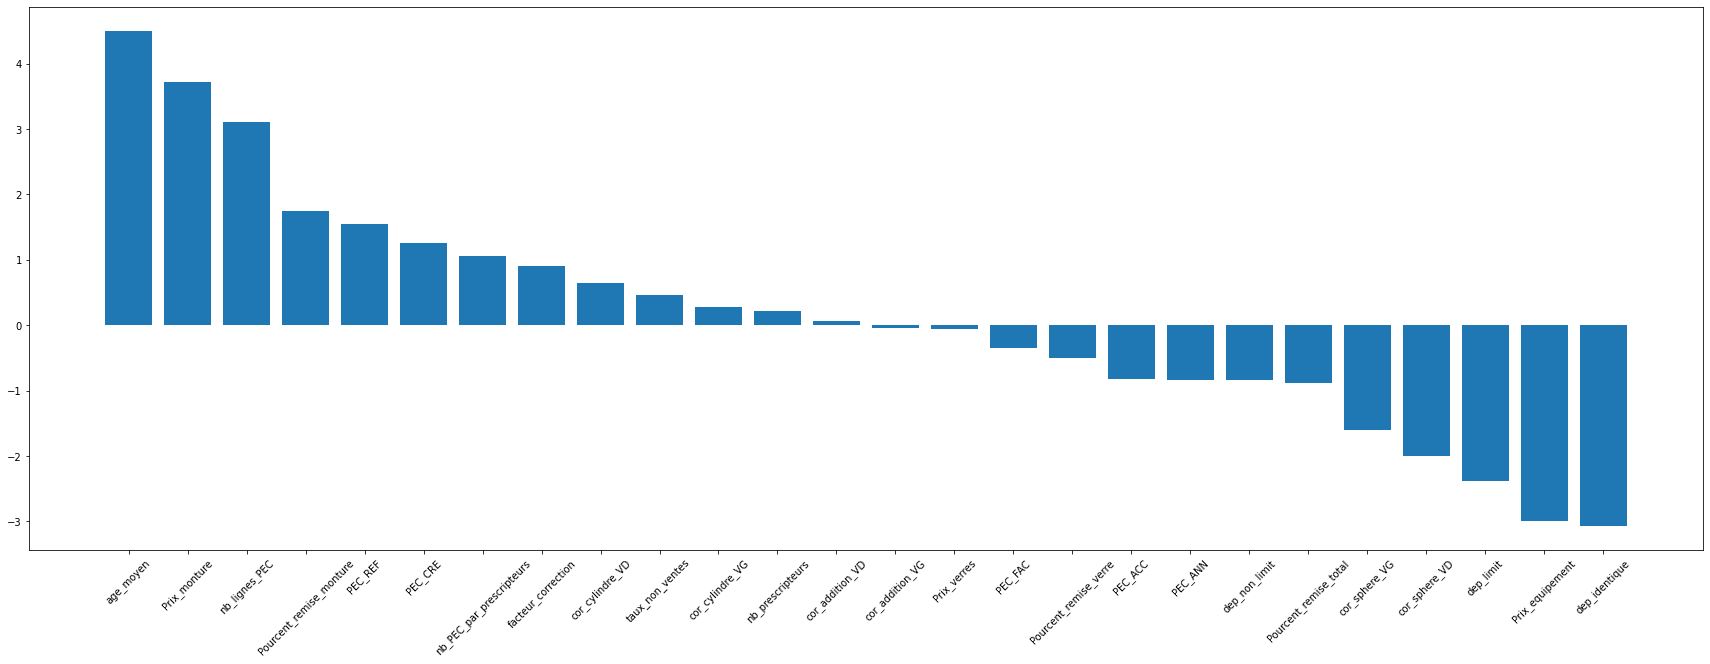

In [191]:
X_tr = pd.DataFrame(X_train)

# Get the values and sort them along with their corresponding labels
sorted_indices = np.argsort((final_score - BC)/BC*100)[::-1]
sorted_values = ((final_score - BC)/BC*100)[sorted_indices]
sorted_labels = np.array(column_names)[sorted_indices]

# Plot the sorted values
plt.bar(range(X_tr.shape[1]), sorted_values)
plt.xticks(range(X_tr.shape[1]), sorted_labels, rotation=45)
np.set_printoptions(False)
plt.savefig('plots/cnn_importance1_ranked.png', bbox_inches='tight')


In [192]:
column_names

['nb_lignes_PEC',
 'dep_identique',
 'dep_limit',
 'dep_non_limit',
 'PEC_CRE',
 'PEC_ANN',
 'PEC_ACC',
 'PEC_FAC',
 'PEC_REF',
 'taux_non_ventes',
 'Prix_monture',
 'Prix_verres',
 'Prix_equipement',
 'Pourcent_remise_verre',
 'Pourcent_remise_monture',
 'Pourcent_remise_total',
 'cor_sphere_VD',
 'cor_cylindre_VD',
 'cor_addition_VD',
 'cor_sphere_VG',
 'cor_cylindre_VG',
 'cor_addition_VG',
 'facteur_correction',
 'age_moyen',
 'nb_prescripteurs',
 'nb_PEC_par_prescripteurs']

### SHAP

In [224]:
# SHAP
# import lifelines
import shap

features = column_names

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [30, 10]


background_data = shap.kmeans(X_train, 100)  # Summarize X_train using 100 cluster centers
e = shap.KernelExplainer(model, background_data)
shap_values = e.shap_values(X_test)

# e = shap.KernelExplainer(model, X_train)
# shap_values = e.shap_values(X_test)


  0%|          | 0/3785 [00:00<?, ?it/s]

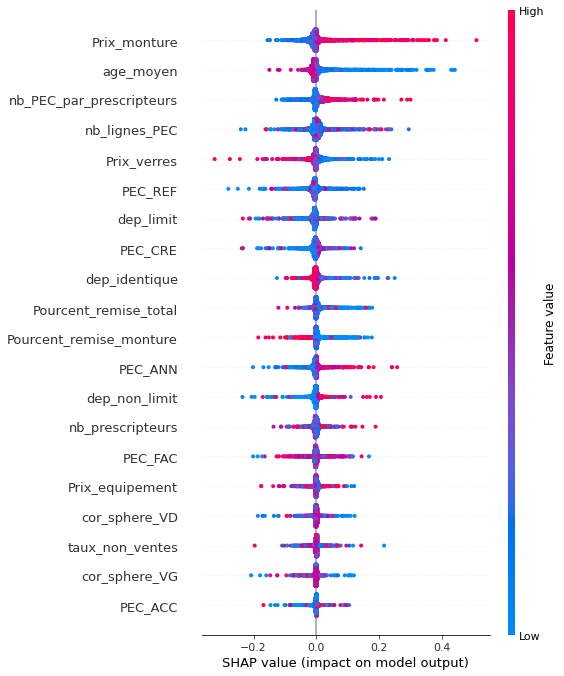

In [225]:
shap.initjs()

shap.summary_plot(shap_values[0], X_test, feature_names=features)
# plt.savefig('plots/cnn_shap1.png', bbox_inches='tight')

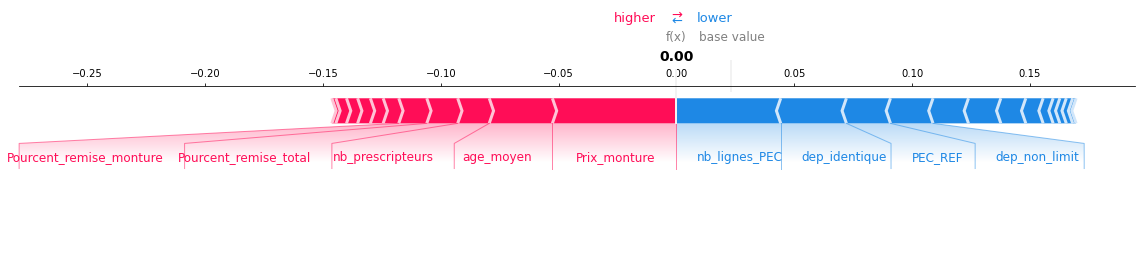

<Figure size 2160x720 with 0 Axes>

In [226]:

# visualize the first prediction's explanation with a force plot
shap.force_plot(e.expected_value[0], shap_values[0][0], features = features, matplotlib=True)
plt.savefig('plots/cnn_shap2.png')

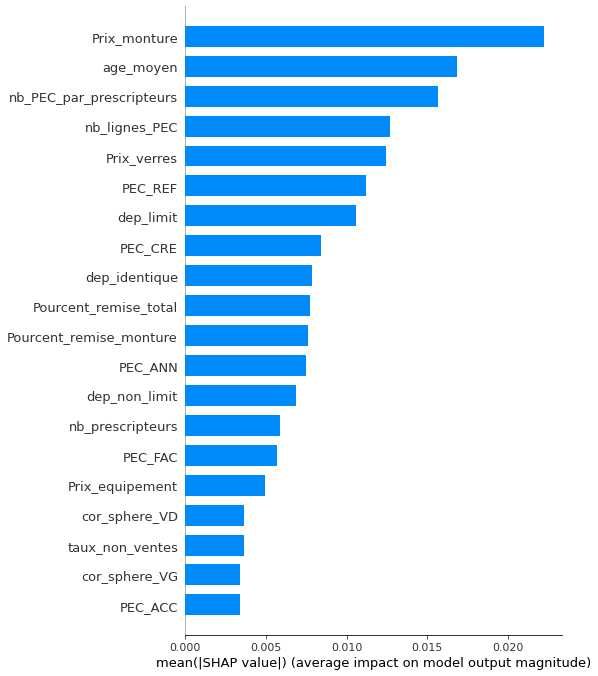

<Figure size 2160x720 with 0 Axes>

In [227]:

shap.summary_plot(shap_values[0], X_test, feature_names=features, plot_type="bar")
plt.savefig('plots/cnn_shap3.png', bbox_inches='tight')
